In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

# pandas and plotting config
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
PATH = 'data/ml-latest-small'

In [4]:
ratings_df = pd.read_csv(f'{PATH}/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movies_df = pd.read_csv(f'{PATH}/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Feature Engineering

In [6]:
combined_df = pd.merge(ratings_df, movies_df, how='left', on='movieId')
combined_df.rename(columns={'title': 'titleYear'}, inplace=True)
combined_df.head()

,userId,movieId,rating,timestamp,titleYear,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [7]:
combined_df['reviewDate'] = pd.to_datetime(combined_df.timestamp, unit='s')
combined_df.head()

,userId,movieId,rating,timestamp,titleYear,genres,reviewDate
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,2009-12-14 02:52:24
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,2009-12-14 02:52:59
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,2009-12-14 02:53:02
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,2009-12-14 02:53:05
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,2009-12-14 02:53:25


In [8]:
movie_yr_df = combined_df.titleYear.str.extract('^(?P<title>.*)\((?P<year>\d+)', expand=False)
movie_yr_df.head()

,title,year
0,Dangerous Minds,1995
1,Dumbo,1941
2,Sleepers,1996
3,Escape from New York,1981
4,Cinema Paradiso (Nuovo cinema Paradiso),1989


In [9]:
combined_df = pd.concat([combined_df, movie_yr_df], axis=1)
combined_df.head()

,userId,movieId,rating,timestamp,titleYear,genres,reviewDate,title,year
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,2009-12-14 02:52:24,Dangerous Minds,1995
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,2009-12-14 02:52:59,Dumbo,1941
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,2009-12-14 02:53:02,Sleepers,1996
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,2009-12-14 02:53:05,Escape from New York,1981
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,2009-12-14 02:53:25,Cinema Paradiso (Nuovo cinema Paradiso),1989


In [10]:
genres = combined_df.genres.str.cat(sep='|').split('|')
u_genres = np.unique(genres)

display(u_genres)

array(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='<U18')

In [11]:
for g in u_genres[1:]:
    combined_df[g] = combined_df.genres.str.contains(g).astype(int)

combined_df.head()

,userId,movieId,rating,timestamp,titleYear,genres,reviewDate,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,2009-12-14 02:52:24,Dangerous Minds,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical,2009-12-14 02:52:59,Dumbo,1941,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller,2009-12-14 02:53:02,Sleepers,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,2009-12-14 02:53:05,Escape from New York,1981,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,2009-12-14 02:53:25,Cinema Paradiso (Nuovo cinema Paradiso),1989,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
combined_df.drop('timestamp', axis=1, inplace=True)
combined_df.drop('titleYear', axis=1, inplace=True)
combined_df.drop('genres', axis=1, inplace=True)

In [13]:
combined_df.head()

,userId,movieId,rating,reviewDate,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,31,2.5,2009-12-14 02:52:24,Dangerous Minds,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1029,3.0,2009-12-14 02:52:59,Dumbo,1941,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1061,3.0,2009-12-14 02:53:02,Sleepers,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1129,2.0,2009-12-14 02:53:05,Escape from New York,1981,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,1,1172,4.0,2009-12-14 02:53:25,Cinema Paradiso (Nuovo cinema Paradiso),1989,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [14]:
display(DataFrameSummary(combined_df).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
userId,100004,347.011,195.164,1,182,367,520,671,100004,671,0,0%,numeric
movieId,100004,12548.7,26369.2,1,1028,2406.5,5418,163949,100004,9066,0,0%,numeric
rating,100004,3.54361,1.05806,0.5,3,4,4,5,100004,10,0,0%,numeric
reviewDate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100004,78141,0,0%,date
title,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001,8833,3,0.00%,categorical
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001,103,3,0.00%,categorical
Action,100004,0.270549,0.444246,0,0,0,1,1,100004,2,0,0%,bool
Adventure,100004,0.220161,0.414357,0,0,0,0,1,100004,2,0,0%,bool
Animation,100004,0.0616975,0.240607,0,0,0,0,1,100004,2,0,0%,bool
Children,100004,0.0867965,0.281538,0,0,0,0,1,100004,2,0,0%,bool


In [15]:
# combined_df.loc[combined_df.title.isnull()]
combined_df.dropna(subset=['year'], how='all', inplace = True)

In [16]:
display(DataFrameSummary(combined_df).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
userId,100001,347.009,195.162,1,182,367,520,671,100001,671,0,0%,numeric
movieId,100001,12544.5,26358.4,1,1028,2406,5418,163949,100001,9063,0,0%,numeric
rating,100001,3.5436,1.05806,0.5,3,4,4,5,100001,10,0,0%,numeric
reviewDate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001,78138,0,0%,date
title,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001,8833,0,0%,categorical
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001,103,0,0%,categorical
Action,100001,0.270557,0.44425,0,0,0,1,1,100001,2,0,0%,bool
Adventure,100001,0.220168,0.414362,0,0,0,0,1,100001,2,0,0%,bool
Animation,100001,0.0616994,0.24061,0,0,0,0,1,100001,2,0,0%,bool
Children,100001,0.0867991,0.281542,0,0,0,0,1,100001,2,0,0%,bool


## Additional feature engineering

In [17]:
add_datepart(combined_df, 'reviewDate', drop=False)
combined_df.head()

,userId,movieId,rating,reviewDate,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,reviewYear,reviewMonth,reviewWeek,reviewDay,reviewDayofweek,reviewDayofyear,reviewIs_month_end,reviewIs_month_start,reviewIs_quarter_end,reviewIs_quarter_start,reviewIs_year_end,reviewIs_year_start,reviewElapsed
0,1,31,2.5,2009-12-14 02:52:24,Dangerous Minds,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759144
1,1,1029,3.0,2009-12-14 02:52:59,Dumbo,1941,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759179
2,1,1061,3.0,2009-12-14 02:53:02,Sleepers,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759182
3,1,1129,2.0,2009-12-14 02:53:05,Escape from New York,1981,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759185
4,1,1172,4.0,2009-12-14 02:53:25,Cinema Paradiso (Nuovo cinema Paradiso),1989,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759205


In [18]:
combined_df.reset_index(inplace=True)
combined_df.to_feather(f'{PATH}/combined_df')

## Prepare dataset for ML

In [19]:
combined_df = pd.read_feather(f'{PATH}/combined_df')
combined_df.drop('index', axis=1, inplace=True)
combined_df.head()

,userId,movieId,rating,reviewDate,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,reviewYear,reviewMonth,reviewWeek,reviewDay,reviewDayofweek,reviewDayofyear,reviewIs_month_end,reviewIs_month_start,reviewIs_quarter_end,reviewIs_quarter_start,reviewIs_year_end,reviewIs_year_start,reviewElapsed
0,1,31,2.5,2009-12-14 02:52:24,Dangerous Minds,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759144
1,1,1029,3.0,2009-12-14 02:52:59,Dumbo,1941,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759179
2,1,1061,3.0,2009-12-14 02:53:02,Sleepers,1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759182
3,1,1129,2.0,2009-12-14 02:53:05,Escape from New York,1981,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759185
4,1,1172,4.0,2009-12-14 02:53:25,Cinema Paradiso (Nuovo cinema Paradiso),1989,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1260759205


In [20]:
# see http://forums.fast.ai/t/understanding-columnarmodeldata-from-data-frame-from-rossman/8140/4?u=wgpubs
combined_df['dummy_cont'] = 1

In [25]:
# 1. define categorical and continuous columns
cat_vars =  list(combined_df.drop(['rating', 'reviewDate', 'reviewElapsed', 'dummy_cont'], axis=1))
cont_vars = ['dummy_cont']
target_var = 'rating'

# cat_vars, cont_vars, target_var

In [26]:
# 2. convert categoricals, continous, and target into correct datatypes
for v in cat_vars: combined_df[v] = combined_df[v].astype('category').cat.as_ordered()
for v in cont_vars: combined_df[v] = combined_df[v].astype(np.float32)
# combined_df[target_var] = combined_df[target_var].astype(np.float32)

raw_train_df = combined_df[cat_vars + cont_vars + [target_var]].copy()

raw_train_df.head(2)

,userId,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,reviewYear,reviewMonth,reviewWeek,reviewDay,reviewDayofweek,reviewDayofyear,reviewIs_month_end,reviewIs_month_start,reviewIs_quarter_end,reviewIs_quarter_start,reviewIs_year_end,reviewIs_year_start,dummy_cont,rating
0,1,31,Dangerous Minds,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1.0,2.5
1,1,1029,Dumbo,1941,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2009,12,51,14,0,348,False,False,False,False,False,False,1.0,3.0


In [27]:
# mapper not returned because we have no continuous vars and so no scaling!
train_df, y, nas, mapper = proc_df(raw_train_df, target_var, do_scale=True)

n = len(train_df); print(n, len(y), nas, len(mapper.features))
train_df.head(2)

100001 100001 {} 1


,userId,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,reviewYear,reviewMonth,reviewWeek,reviewDay,reviewDayofweek,reviewDayofyear,reviewIs_month_end,reviewIs_month_start,reviewIs_quarter_end,reviewIs_quarter_start,reviewIs_year_end,reviewIs_year_start,dummy_cont
0,1,31,1931,82,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,15,12,51,14,1,348,1,1,1,1,1,1,0.0
1,1,834,2352,28,1,1,2,2,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,15,12,51,14,1,348,1,1,1,1,1,1,0.0


In [28]:
val_idxs = get_cv_idxs(n)
len(val_idxs)

20000

In [29]:
y_range = [0.0, 5.0]

In [30]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, train_df, y.astype(np.float32), cat_flds=cat_vars, bs=64)

In [31]:
cat_szs = [ (v, len(raw_train_df[v].cat.categories) + 1) for v in cat_vars ]
cat_szs

[('userId', 672),
 ('movieId', 9064),
 ('title', 8834),
 ('year', 104),
 ('Action', 3),
 ('Adventure', 3),
 ('Animation', 3),
 ('Children', 3),
 ('Comedy', 3),
 ('Crime', 3),
 ('Documentary', 3),
 ('Drama', 3),
 ('Fantasy', 3),
 ('Film-Noir', 3),
 ('Horror', 3),
 ('IMAX', 3),
 ('Musical', 3),
 ('Mystery', 3),
 ('Romance', 3),
 ('Sci-Fi', 3),
 ('Thriller', 3),
 ('War', 3),
 ('Western', 3),
 ('reviewYear', 23),
 ('reviewMonth', 13),
 ('reviewWeek', 54),
 ('reviewDay', 32),
 ('reviewDayofweek', 8),
 ('reviewDayofyear', 367),
 ('reviewIs_month_end', 3),
 ('reviewIs_month_start', 3),
 ('reviewIs_quarter_end', 3),
 ('reviewIs_quarter_start', 3),
 ('reviewIs_year_end', 3),
 ('reviewIs_year_start', 3)]

In [32]:
emb_szs = [ (csz, min(50, (csz+1) // 2)) for _, csz in cat_szs ]
emb_szs

[(672, 50),
 (9064, 50),
 (8834, 50),
 (104, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (23, 12),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [33]:
learner = md.get_learner(emb_szs, len(train_df.columns)-len(cat_vars), 
                         0.04, 1, [1000, 500], [0.001, 0.01], y_range=y_range)

In [34]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       3.21341  3.1868 ]                                  



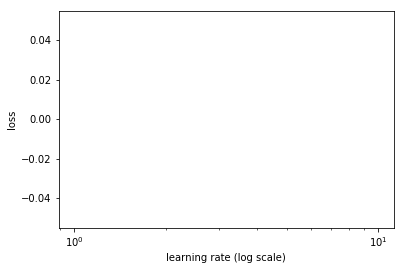

In [35]:
learner.sched.plot()

In [36]:
lr = 1e-3

In [37]:
learner.fit(lr, 3, wds=0.025, use_wd_sched=True, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.80371  0.78126]                                   
[ 1.       0.77719  0.75893]                                   
[ 2.       0.68839  0.76158]                                   



In [38]:
learner.fit(lrs=lr, n_cycle=1, wds=0.025, use_wd_sched=True, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.73018  0.76641]                                   
[ 1.       0.62653  0.75006]                                   
[ 2.      0.5283  0.7656]                                      



In [39]:
preds, actuals = learner.predict_with_targs()

In [42]:
F.mse_loss(V(preds), V(actuals))

Variable containing:
 0.7654
[torch.FloatTensor of size 1]

In [40]:
preds[:10], actuals[:10]

(array([[ 2.83586],
        [ 3.62712],
        [ 3.3094 ],
        [ 3.7199 ],
        [ 3.06904],
        [ 3.68695],
        [ 3.64052],
        [ 3.56796],
        [ 3.99228],
        [ 3.92696]], dtype=float32), array([[ 3.5],
        [ 4. ],
        [ 3. ],
        [ 1. ],
        [ 4. ],
        [ 4. ],
        [ 3. ],
        [ 3. ],
        [ 4. ],
        [ 4. ]], dtype=float32))

## Custom Dataset, DataLoader, and NN

In [43]:
# cat_vars
cat_cols = []
for c in cat_vars:
    n = len(raw_train_df[c].cat.categories) + 1
    cat_cols.append({ c: {'n': n, 'dims': min(50, (n+1) // 2)} })
    
cat_cols[0]

{'userId': {'dims': 50, 'n': 672}}

In [44]:
class DfDataset(Dataset):
    def __init__(self, df, cats, y=None):
        self.n = len(df)
        cat_cols = [ list(col)[0] for col in cats ]
        cont_cols = [ c for c in list(df) if c not in cat_cols ]
        
        self.cats = df[cat_cols].astype(np.int64).as_matrix() if cat_cols else np.zeros((self.n,1))
        self.conts = df.drop(cat_cols, axis=1).astype(np.float32).as_matrix() if cont_cols else np.zeros((self.n,1))
        self.y = y if not y is None else np.zeros((n,1))
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [45]:
class DfModelData(ModelData):
    def __init__(self, path, bs, trn_ds, val_ds, test_ds=None, shuffle=True):
        train_dl = DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1)
        val_dl = DataLoader(val_ds, bs*2, shuffle=False, num_workers=1) if val_ds is not None else None
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        
        super().__init__(path, train_dl, val_dl, test_dl)

    @classmethod
    def from_df(cls, path, df, val_idxs, y, cat_flds, bs, test_df=None):
        val_df = df.iloc[val_idxs] if len(val_idxs) > 0 else None
        val_y = y[val_idxs] if len(val_idxs) > 0 else None
        
        trn_df = df.drop(val_idxs)
        trn_y = np.delete(y, val_idxs)
        
        return cls(path, bs,
                   DfDataset(trn_df, cat_flds, trn_y),
                   DfDataset(val_df, cat_flds, val_y) if val_df is not None else None, 
                   DfDataset(test_df, cat_flds) if test_df is not None else None)

In [46]:
def emb_init(emb):
    emb = emb.weight.data
    sc = 2 / (emb.size(1)+1)
    emb.uniform_(-sc,sc)


class MixedInputModel(nn.Module):
    def __init__(self, cont_cols, emb_cols, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        
        self.cont_cols = cont_cols
        self.emb_cols = [ list(emb)[0] for emb in emb_cols ]
        
        self.emb_lookup = {}
        for emb in emb_cols:
            emb_key = list(emb)[0]
            self.emb_lookup[emb_key] = nn.Embedding(emb[emb_key]['n'], emb[emb_key]['dims'])
        self.embs = nn.ModuleList(list(self.emb_lookup.values()))
        self.emb_drop = nn.Dropout(emb_drop)
        for emb in self.embs: emb_init(emb)
            
        total_emb_dims = sum(e.embedding_dim for e in self.embs)
        szs = [total_emb_dims + len(cont_cols)] + szs
        
        self.lins = nn.ModuleList([ nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1) ])
        self.bns = nn.ModuleList([ nn.BatchNorm1d(sz) for sz in szs[1:] ])
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        for o in self.lins: kaiming_normal(o.weight.data)
            
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.bn = nn.BatchNorm1d(len(cont_cols))
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        
        x2 = self.bn(x_cont)
        x = torch.cat([x, x2], 1)
        
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
            
        x = self.outp(x)
        
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
            
        return x

In [47]:
ds = DfDataset(train_df, cat_cols, y.astype(np.float32))

In [48]:
md = DfModelData.from_df(PATH, train_df, val_idxs, y.astype(np.float32), cat_cols, bs=64)

In [49]:
len(md.trn_ds), len(md.val_ds), len(md.trn_dl), len(md.val_dl), md.trn_dl.batch_size, md.val_dl.batch_size

(80001, 20000, 1251, 157, 64, 128)

In [50]:
# next(iter(md.trn_dl))

In [53]:
wd=1e-5
model = MixedInputModel(cont_vars, cat_cols, 0.04, 1, [1000, 500], [0.001, 0.01], y_range=y_range).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [54]:
fit(model, md, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  8%|▊         | 104/1251 [00:02<00:22, 50.72it/s, loss=1.02]


 17%|█▋        | 218/1251 [00:03<00:16, 62.58it/s, loss=0.929]


 26%|██▌       | 324/1251 [00:04<00:14, 65.78it/s, loss=0.885]


 35%|███▌      | 441/1251 [00:06<00:11, 68.97it/s, loss=0.836]


 44%|████▎     | 545/1251 [00:07<00:10, 68.51it/s, loss=0.815]


 53%|█████▎    | 657/1251 [00:09<00:08, 69.55it/s, loss=0.791]


 61%|██████▏   | 769/1251 [00:10<00:06, 70.22it/s, loss=0.816]


 71%|███████   | 882/1251 [00:12<00:05, 71.27it/s, loss=0.794]


 79%|███████▉  | 990/1251 [00:13<00:03, 71.71it/s, loss=0.774]


 88%|████████▊ | 1095/1251 [00:15<00:02, 71.88it/s, loss=0.776]


 96%|█████████▋| 1206/1251 [00:16<00:00, 72.56it/s, loss=0.804]


100%|█████████▉| 1246/1251 [00:17<00:00, 72.57it/s, loss=0.793]
                                                               [ 0.       0.79263  0.77296]

  5%|▍         | 60/1251 [00:01<00:30, 39.54it/s, loss=0.719]


 14%|█▍        | 174/1251 [00:02<00:18, 58.82it/s, loss=0.718]


 22%|██▏       | 279/1251 [00:04<00:15, 62.32it/s, loss=0.709]


 31%|███▏      | 393/1251 [00:05<00:12, 66.50it/s, loss=0.716]


 40%|████      | 505/1251 [00:07<00:11, 67.67it/s, loss=0.705]


 49%|████▉     | 611/1251 [00:08<00:09, 68.01it/s, loss=0.712]


 58%|█████▊    | 724/1251 [00:10<00:07, 69.26it/s, loss=0.723]


 66%|██████▋   | 831/1251 [00:11<00:06, 69.51it/s, loss=0.721]


 75%|███████▌  | 944/1251 [00:13<00:04, 70.42it/s, loss=0.71]


 84%|████████▍ | 1056/1251 [00:14<00:02, 71.21it/s, loss=0.727]


 93%|█████████▎| 1160/1251 [00:16<00:01, 71.01it/s, loss=0.722]


100%|█████████▉| 1249/1251 [00:17<00:00, 71.47it/s, loss=0.718]
                                                               [ 1.       0.71756  0.75618]

  1%|▏         | 17/1251 [00:00<00:53, 22.86it/s, loss=0.704]


 10%|█         | 128/1251 [00:02<00:19, 57.17it/s, loss=0.625]


 19%|█▉        | 240/1251 [00:03<00:15, 63.84it/s, loss=0.642]


 27%|██▋       | 344/1251 [00:05<00:13, 65.66it/s, loss=0.649]


 36%|███▋      | 456/1251 [00:06<00:11, 67.46it/s, loss=0.628]


 45%|████▌     | 565/1251 [00:08<00:10, 67.76it/s, loss=0.644]


 54%|█████▍    | 677/1251 [00:09<00:08, 68.69it/s, loss=0.654]


 63%|██████▎   | 790/1251 [00:11<00:06, 69.73it/s, loss=0.675]


 72%|███████▏  | 901/1251 [00:12<00:05, 69.96it/s, loss=0.654]


 80%|████████  | 1006/1251 [00:14<00:03, 70.19it/s, loss=0.638]


 89%|████████▉ | 1118/1251 [00:15<00:01, 70.67it/s, loss=0.657]


 98%|█████████▊| 1228/1251 [00:17<00:00, 71.21it/s, loss=0.674]


100%|██████████| 1251/1251 [00:17<00:00, 71.23it/s, loss=0.679]
                                                               [ 2.       0.67852  0.75364]



Getting 0.75364 MSE.  Nice!

### Evaluate embeddings

In [58]:
g = raw_train_df.groupby(['movieId', 'title'])['rating'].count()
top_movies_df = g.sort_values(ascending=False).reset_index()[:3000]

In [59]:
top_movies_df['movieIdCode'] = top_movies_df.movieId.cat.codes
top_movies_df.sort_values(by='rating', ascending=False, inplace=True)

In [60]:
len(top_movies_df)

3000

In [61]:
user_emb = model.emb_lookup['movieId']

In [62]:
movie_emb = to_np(user_emb(V(top_movies_df.movieIdCode.as_matrix())))
movie_emb.shape

(3000, 50)